Ok. Like for the audio testing I will do some bvh testing. I think after investigating it a bit further that it does not make sense to get rid of bvh2features and features2bvh, at least for now. Maybe in the future we can do our own bvh converters and get rid of sklearn, and probably make it faster as well, but I dont think it's needed right now. One possibility is to use the bvh importer that is integrated in blender, and to actually work with the data inside blender. That would allow us to visualize everything nicely while working with the data, but will probably also add a lot of complexity. But it could be nice to have a UI to visualize it, and to see the diffusion process as it is occuring and gestures are being refined. 

I have a vague idea that animation diffusion could be used as a tool in animation software. For instance, you could animate a coarse gesture, select part of the timeline and click "refine", and then let the unconditioned diffusion model refine the gesture. That could be interesting at least, possibly slightly controversial


What I will do for now is some experiments with bvh to see how the data works, and what can be done with it.

Let me start by importing a test bvh file

In [5]:
# Import test bvh file

# bvhconverters folder is one level up from the current folder
import sys
sys.path.append('bvh_converters')

from bvh_converters.bvh_converter import BVHConverter

bvh_file = 'bvh_tests/bvh/trn_2023_v0_000_main-agent.bvh'

converter = BVHConverter()

embedded_bvh = converter.to_features(bvh_file)

print("RESULT:")
print(embedded_bvh.shape)

downsampling with rate: 1
JointSelector
MocapParameterizer: expmap


c:\Users\anton\Desktop\gesture_generation\GestureGeneration\DiffuseStyleGestureReproduced\bvh_converters\pymo\preprocessing.py:200: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  exp_df.insert(loc=0, column='%s_gamma'%joint, value=pd.Series(data=[e[2] for e in exps], index=exp_df.index))
c:\Users\anton\Desktop\gesture_generation\GestureGeneration\DiffuseStyleGestureReproduced\bvh_converters\pymo\preprocessing.py:201: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  exp_df.insert(loc=0, column='%s_beta'%joint, value=pd.Series(data=[e

Numpyfier
RESULT:
(1949, 336)


c:\Users\anton\Desktop\gesture_generation\GestureGeneration\DiffuseStyleGestureReproduced\bvh_converters\pymo\preprocessing.py:200: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  exp_df.insert(loc=0, column='%s_gamma'%joint, value=pd.Series(data=[e[2] for e in exps], index=exp_df.index))
c:\Users\anton\Desktop\gesture_generation\GestureGeneration\DiffuseStyleGestureReproduced\bvh_converters\pymo\preprocessing.py:201: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  exp_df.insert(loc=0, column='%s_beta'%joint, value=pd.Series(data=[e

It works, and the dimension is more or less what I expected. Here the length is 1949. The length of the audio embeddings are 1952 (even that is after cropping some of the features). But it makes sense that the audio is maybe not perfectly aligned in length. 

Those warnings are really annoying though. Maybe it would be a good idea to rewrite the converter after all.

Ok. Now I will try to construct a noisy pose. How hard can that be?
I have to sample noise from a gaussian, which I actually don't quite know what means in the context of joint rotations

In [ ]:
# I want to add noise to the embedded bvh to experiment before implementing diffusion

# I have to sample noise from a normal distribution with mean 0 and std 1
import numpy as np

noise = np.random.normal(0, 1, embedded_bvh.shape)
print(noise)

# In diffusion training I will sample a timestep t uniformly and add noise to the embedded bvh at timestep t

t = 0.01

# Now I add noise and remove information accoding to the diffusion model noise formula thing
# I still do not understand this formula. To me it would make much more sense without the square root.
# Then you would remove information from the embedded bvh and add noise to it in a linear way.
# Of course smart people have thought about this, and its inspired by physics, so I will just go with it for now.
diffused_bvh = np.sqrt(1 - t) * embedded_bvh + np.sqrt(t) * noise

print(diffused_bvh)

# Now I would like to convert the diffused bvh back to a bvh file and see if it looks like the original bvh file
converter.to_bvh(diffused_bvh, 'bvh_tests/results/result.bvh')



[[ 1.76794908 -0.65807497 -0.36773767 ... -0.70561203  1.73634394
  -0.16441527]
 [-0.827483    1.64214133  1.25129337 ...  0.54020844 -0.18322953
  -0.76530788]
 [ 0.57388446 -1.68453042 -0.54747401 ...  1.61567455  0.72624846
  -0.52360728]
 ...
 [-0.73285618 -0.47295785 -0.22470456 ... -1.05996006  0.80898692
  -1.45235243]
 [-0.3025586  -1.11838881 -2.59757428 ... -0.22473032 -1.25080896
  -2.14601134]
 [-0.0141766   0.16597233 -1.14919638 ... -0.00828248  0.13828199
  -0.0998729 ]]
[[ 1.64638843e-01 -6.58074967e-02 -3.67737672e-02 ... -7.05612033e-02
   6.48692918e+00  3.15343920e+00]
 [-9.49043648e-02  1.64214133e-01  1.25129337e-01 ...  5.40208441e-02
   6.29497183e+00  3.09334994e+00]
 [ 4.52323808e-02 -1.68453042e-01 -5.47474007e-02 ...  1.61567455e-01
   6.38591963e+00  3.11752000e+00]
 ...
 [ 3.60859552e-01 -4.72957855e-02 -2.24704562e-02 ... -1.05996006e-01
   6.39419348e+00  3.02464548e+00]
 [ 4.07362472e-01 -1.11838881e-01 -2.59757428e-01 ... -2.24730319e-02
   6.18821389

c:\Users\anton\Desktop\gesture_generation\GestureGeneration\DiffuseStyleGestureReproduced\bvh_converters\pymo\preprocessing.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  euler_df['%s_%srotation'%(joint, rot_order[0])] = pd.Series(data=[e[0] for e in euler_rots], index=euler_df.index)
c:\Users\anton\Desktop\gesture_generation\GestureGeneration\DiffuseStyleGestureReproduced\bvh_converters\pymo\preprocessing.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  euler_df['%s_%srotation'%(joint, rot_order[1])] = pd.Series(dat

I opened the resulting file in blender. it is VERY noisy. The original animation is completely lost it feels like. And that is at 10 % noise? But at least there is noise. And maybe it doesnt scale linearly or something? I know that we are using exponential representation of rotation, although I dont know what that means exactly. It would be nice to be able to plot the animation in the notebook directly. I have found a library called bvhsdk, which seems to be able to do it. And also importing / converting. Maybe that can be the solution instead of pymo? Although as far as I can tell it does not have the exponential representation of rotation which is supposed to be good for machine learning. Maybe we can add that manually. 

Let me try and plot the animations in the notebook using this library

Note: you may need to restart the kernel to use updated packages.
Precomputing positions...


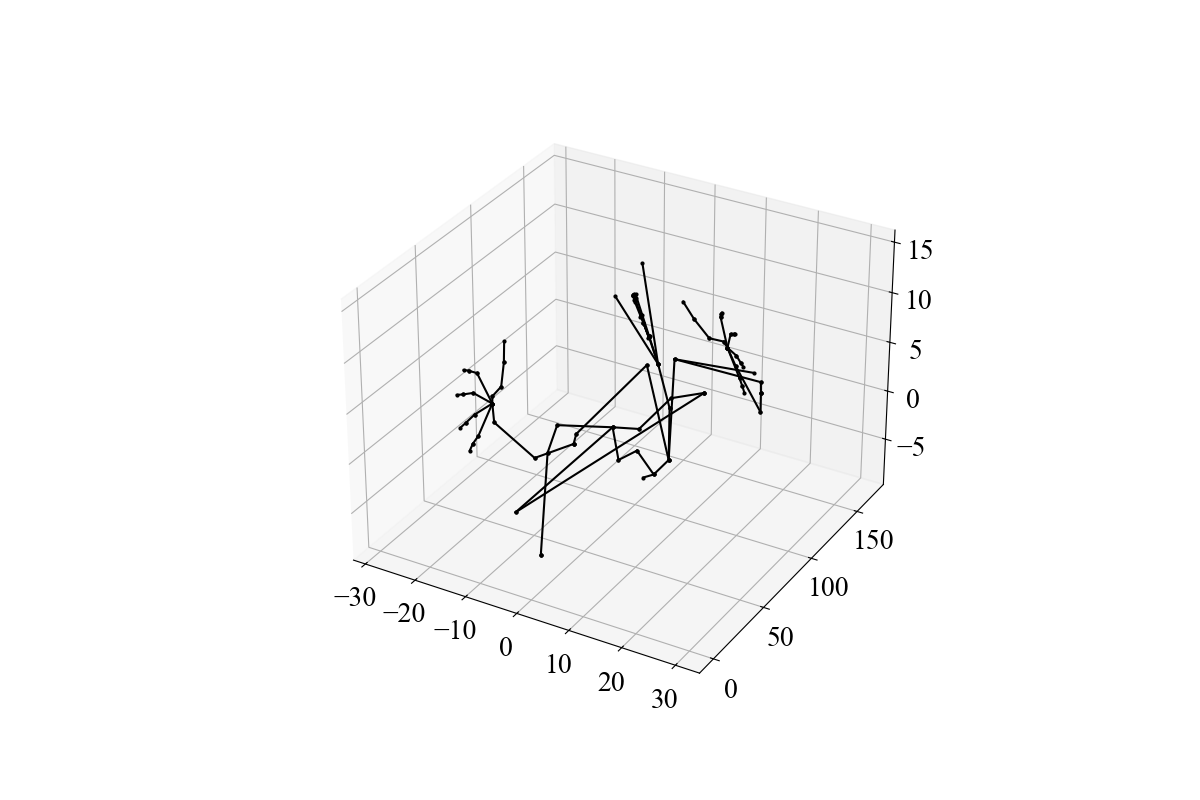

In [ ]:
%matplotlib ipympl
import bvhsdk
import os
original_bvh_file = 'bvh_tests/bvh/trn_2023_v0_000_main-agent.bvh'
diffused_bvh_file = 'bvh_tests/results/result.bvh'

original_anim = bvhsdk.ReadFile(original_bvh_file)
diffused_anim = bvhsdk.ReadFile(diffused_bvh_file)

orignal_anim_visualized = bvhsdk.plotanimation.plot3d(original_anim)
